# SK하이닉스 리더십 뉴스 데이터 분석

이 노트북에서는 SK하이닉스의 리더십 관련 뉴스 데이터를 분석하고 시각화합니다.

In [1]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import Mecab
from collections import Counter
import re
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.font_manager as fm
# 2-gram 분석을 위한 함수 재정의
from nltk import bigrams as nltk_bigrams

# 나눔고딕 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 폰트 캐시 초기화 (최신 방식)
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
# 데이터 로드
df = pd.read_csv('data/skhynix/leadership_news.csv')

# 날짜 형식 변환
df['date'] = pd.to_datetime(df['date'])

# 기본 데이터 확인
print("데이터 크기:", df.shape)
print("\n컬럼 정보:")
print(df.info())
print("\n처음 5개 행:")
display(df.head())

데이터 크기: (120, 6)

컬럼 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     120 non-null    object        
 1   url       120 non-null    object        
 2   date      120 non-null    datetime64[ns]
 3   category  120 non-null    object        
 4   tags      119 non-null    object        
 5   content   120 non-null    object        
dtypes: datetime64[ns](1), object(5)
memory usage: 5.8+ KB
None

처음 5개 행:


title  \
0  [2025 신임임원 인터뷰 5편] SK하이닉스 HBM사업기획 최준용 부사장 “HBM...   
1  [2025 신임임원 인터뷰 4편] SK하이닉스 SKMS&Growth 이송만 부사장 ...   
2  SK하이닉스 장태수 부사장, 제52회 상공의 날 대통령 표창 수상 “세계 최초 10...   
3  SK하이닉스, GTC 2025서 독보적인 AI 메모리 기술 리더십 선봬\n...의 ...   
4  [2025 신임임원 인터뷰 2편] SK하이닉스 경영분석 엄재광 부사장 “균형 잡힌 ...   

                                                 url       date     category  \
0  https://news.skhynix.co.kr/2025-new-executive-... 2025-04-07    CULTURE &   
1  https://news.skhynix.co.kr/2025-new-executive-... 2025-03-31    CULTURE &   
2  https://news.skhynix.co.kr/award-on-commerce-a... 2025-03-20    CULTURE &   
3               https://news.skhynix.co.kr/gtc-2025/ 2025-03-19  TECH & AI &   
4  https://news.skhynix.co.kr/2025-new-executive-... 2025-03-10    CULTURE &   

                            tags  \
0            HBM, 사업기획, 신임임원 인터뷰   
1      HRD, SKHU, SKMS, 신임임원 인터뷰   
2  1cDDR5, D램, 대통령표창, 미세공정, 상공의날   
3  AI, D램, eSSD, GTC, HBM, 낸드플래시   
4                 경영분석, 신임임원 인터뷰   

                                             content  
0  AI 기술의 발전과 함께 이를 뒷받침하는 고대역폭메모리, HBM의 비약적인 성장은 ...  
1  SK하이닉스 경영의 중심에는 ‘SKMS(SK Management System)’가 ...  
2  제52회 상공의 날 기념 행사에서 대통령 표창을 받은 SK하이닉스 장태수 부사장(미...  
3  SK하이닉스가 3월 17일부터 21일(현지 시간)까지 미국 캘리포니아주 새너제이(S...  
4  SK하이닉스는 지난 2024년, 창사 이래 최대 실적을 기록하며 글로벌 AI 메모리...

## 1. 기본 데이터 분석

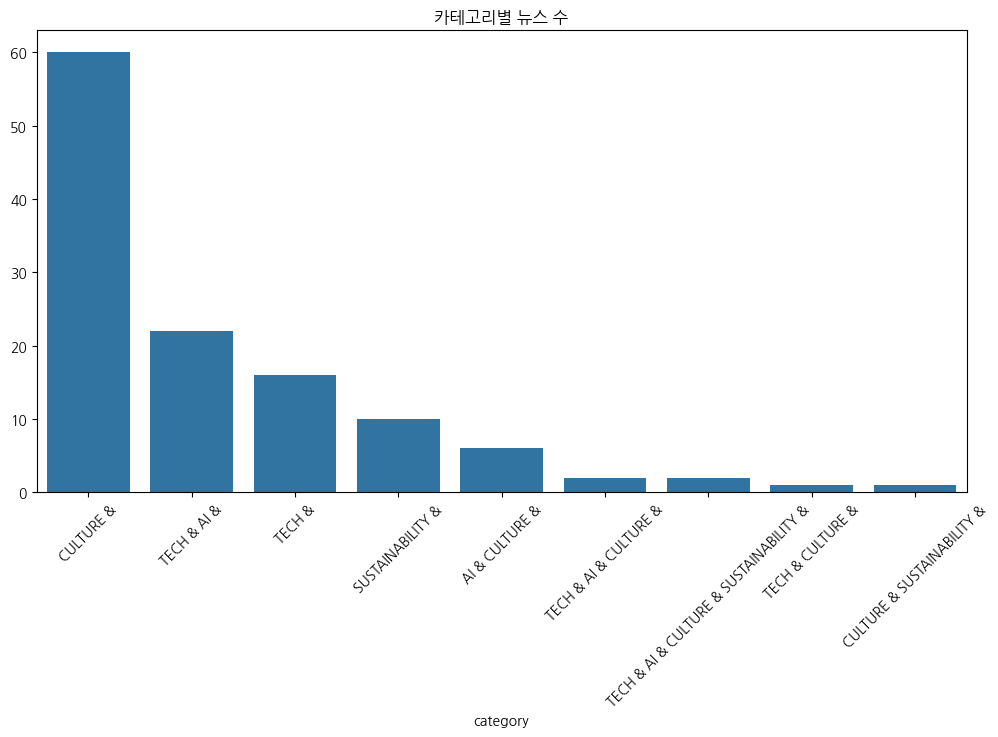

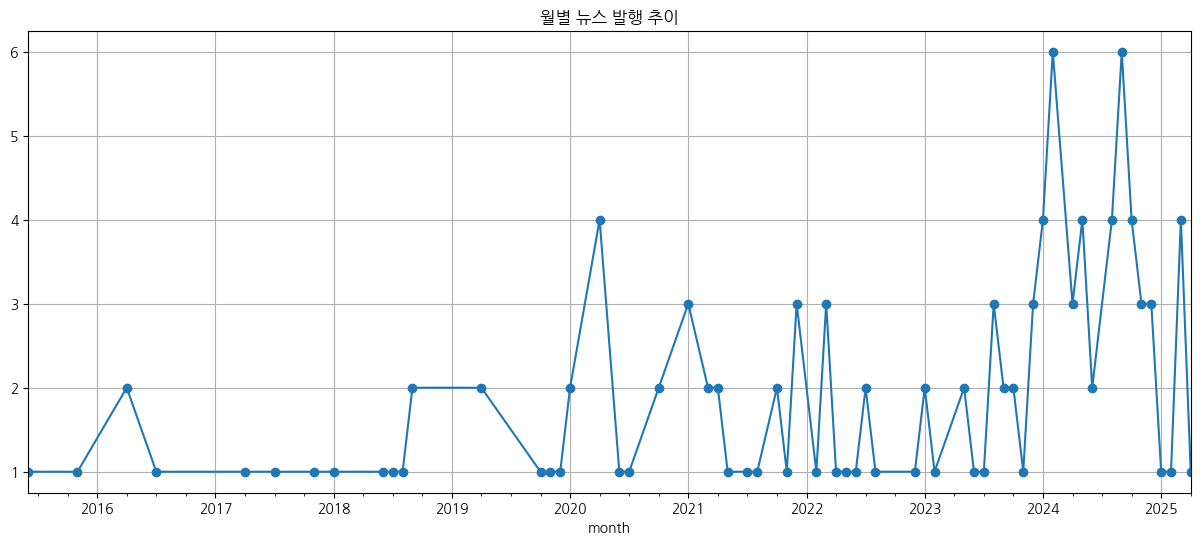

In [2]:
# 카테고리별 뉴스 수 분석
category_counts = df['category'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('카테고리별 뉴스 수')
plt.xticks(rotation=45)
plt.show()

# 월별 뉴스 발행 추이
df['month'] = df['date'].dt.to_period('M')
monthly_counts = df.groupby('month').size()
plt.figure(figsize=(15, 6))
monthly_counts.plot(kind='line', marker='o')
plt.title('월별 뉴스 발행 추이')
plt.grid(True)
plt.show()

## 2. 텍스트 분석 준비
1. 도메인 키워드를 카테고리별로 구조화하여 정의
- 리더십 관련 키워드
- 반도체 기술/제품 관련 키워드
- 기업명
- 기술 관련 키워드
2. 영어-한글 혼합 형태 보존
- HBM, DDR5 등의 기술 명칭
- SK하이닉스와 같은 기업명
3. 특수문자와 숫자 처리 개선
- 1αnm, HBM3E 등의 기술 명칭 보존
- 특수문자 제거 시 도메인 키워드는 보존
4. 형태소 분석 시 의미 있는 단어 추출 기준 개선
- 도메인 키워드는 무조건 보존
- 영어-한글 혼합 형태 보존
- 일반 명사, 형용사, 동사 중 의미 있는 것만 추출
5. 2-gram 분석 추가
- 연속된 단어들의 패턴을 파악하여 의미 있는 문구 추출

In [3]:
# 도메인 키워드 정의
domain_keywords = {
    'leadership': [
        '양손잡이 리더십', 'Ambidextrous Leadership', '탐색', 'Exploration', '활용', 'Exploitation',
        'CEO', '사장', '대표이사', '회장', '경영진', '임원', '수석', '총괄', '책임자', '이사',
        '경영', '전략', '비전', '혁신', '변화', '성과', '성장', '개발', '연구', '투자'
    ],
    'semiconductor': [
        'HBM', 'HBM1', 'HBM2', 'HBM2E', 'HBM3', 'HBM3E', 'HBM4',
        'DDR4', 'DDR5', 'DDR6', 'LPDDR6',
        'DRAM', 'D램', 'NAND', '낸드', '플래시',
        'TSV', 'Through Silicon Via',
        '1αnm', '1-alpha', '1γnm', '1-gamma', '1δnm', '1-delta',
        'VG DRAM', 'Vertical Gate', '3D DRAM',
        '파운드리', '팹리스', '패키징', '웨이퍼'
    ],
    'companies': [
        'SK하이닉스', 'SK hynix', '삼성전자', 'TSMC', '인텔', '마이크론',
        '퀄컴', 'AMD', '엔비디아', '아마존', '구글', '애플'
    ],
    'technology': [
        'AI', '인공지능', '빅데이터', '클라우드', '5G', '6G', 'IoT',
        '자율주행', '메타버스', '양자컴퓨팅', '로봇', '자동화',
        '스마트팩토리', '디지털트랜스포메이션'
    ]
}

# 모든 도메인 키워드를 하나의 리스트로 통합
all_domain_keywords = [keyword for keywords in domain_keywords.values() for keyword in keywords]

# 영어-한글 혼합 패턴 정의
mixed_pattern = re.compile(r'[A-Za-z]+[가-힣]+|[가-힣]+[A-Za-z]+')

# 제거할 품사 태그 정의
remove_pos = {'JKS', 'JKO', 'JKB', 'JX', 'JC', 'EP', 'EF', 'EC', 'ETN', 'ETM'}

# Mecab 초기화
mecab = Mecab()

def preprocess_text(text):
    if pd.isna(text):
        return ''
    
    # 도메인 키워드 보존
    for keyword in all_domain_keywords:
        text = text.replace(keyword, f' {keyword} ')
    
    # 영어-한글 혼합 형태 보존
    mixed_words = set(mixed_pattern.findall(text))
    
    # 특수문자 제거 (단, 도메인 키워드와 영어-한글 혼합 형태는 보존)
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # 형태소 분석
    pos = mecab.pos(text)
    
    # 의미 있는 단어 추출
    words = []
    for word, pos_tag in pos:
        # 영어-한글 혼합 형태는 보존
        if word in mixed_words:
            words.append(word)
            continue
            
        # 도메인 키워드는 보존
        if word in all_domain_keywords:
            words.append(word)
            continue
            
        # 일반 명사, 형용사, 동사 추출 (조사, 어미 등 제외)
        if pos_tag in ['NNG', 'NNP', 'VA', 'VV'] and pos_tag not in remove_pos:
            # 한 글자 한자어 제외
            if not (len(word) == 1 and '\u4e00' <= word <= '\u9fff'):
                words.append(word)
    
    return ' '.join(words)

# 텍스트 전처리 적용
df['processed_content'] = df['content'].apply(preprocess_text)

# 샘플 출력
print("전처리된 텍스트 샘플:")
print(df['processed_content'].iloc[0][:200])

# 도메인 키워드 등장 빈도 확인
keyword_freq = {}
for keyword in all_domain_keywords:
    freq = sum(1 for text in df['processed_content'] if keyword in text)
    if freq > 0:
        keyword_freq[keyword] = freq

print("\n도메인 키워드 등장 빈도:")
for keyword, freq in sorted(keyword_freq.items(), key=lambda x: x[1], reverse=True):
    print(f"{keyword}: {freq}회")

# 2-gram 분석
from nltk import bigrams
import nltk
nltk.download('punkt')

# 2-gram 추출
bigram_list = []
for text in df['processed_content']:
    words = text.split()
    bigram_list.extend(list(bigrams(words)))

# 2-gram 빈도수 계산
bigram_freq = Counter(bigram_list)

print("\n자주 등장하는 2-gram:")
for (word1, word2), count in bigram_freq.most_common(20):
    print(f"{word1} {word2}: {count}")

전처리된 텍스트 샘플:
AI 기술 발전 뒷받침 대역폭 메모리 HBM 비약 성장 지난해 하이닉스 달성 사상 최대 실적 기여 업계 하이닉스 성장 매출 증가 넘 AI 시대 패러다임 주도 변화 신호탄 평가 흐름 반영 하이닉스 최근 조직 개편 단행 젊 혁신 리더십 강화 최준용 부 사장 HBM 사업 기획 총괄 임원 선임 업계 주목 받 모바일 램 상품 기획 팀장 거치 HBM 사업 기획 담당 

도메인 키워드 등장 빈도:
개발: 105회
성과: 78회
성장: 73회
혁신: 67회
활용: 65회
연구: 63회
AI: 63회
변화: 61회
HBM: 57회
사장: 47회
전략: 44회
경영: 41회
비전: 38회
투자: 36회
낸드: 36회
DRAM: 32회
임원: 31회
NAND: 27회
웨이퍼: 26회
인공지능: 23회
플래시: 20회
총괄: 17회
인텔: 16회
CEO: 15회
이사: 15회
TSV: 15회
클라우드: 11회
회장: 9회
파운드리: 9회
TSMC: 6회
애플: 6회
탐색: 4회
수석: 4회
IoT: 4회
책임자: 3회
삼성전자: 3회
구글: 3회
퀄컴: 2회
아마존: 2회
로봇: 2회
AMD: 1회
자동화: 1회

자주 등장하는 2-gram:
부 사장: 253
AI 메모리: 140
관련 기사: 130
기술 개발: 104
제품 개발: 100
데이터 센터: 99
낸드 플래시: 82
협 력사: 76
세계 최초: 71
지속 가능: 71
메모리 반도체: 66
HBM 개발: 65
키 징: 63
미래 기술: 60
데이터 처리: 56
기술 리더십: 54
하이닉스 HBM: 53
연구 원: 52
플랫 폼: 50
지식 블로그: 50


[nltk_data] Downloading package punkt to /home/arkwith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 3. 리더십 키워드 분석
1. 도메인 키워드를 카테고리별로 구분하여 시각화
 - 리더십 관련 키워드
 - 반도체 기술/제품 관련 키워드
 - 기업명
기술 관련 키워드
2. 연도별 키워드 추이 분석 추가
 - 각 카테고리별 키워드의 연도별 등장 빈도 추이 시각화
 - 카테고리별로 구분하여 시각화
3. 2-gram 분석 결과 시각화 추가
 - 전체 기간 동안의 주요 2-gram 시각화
 - 연도별 주요 2-gram 시각화
4. 키워드 간 상관관계 분석 추가
 - 키워드 간 동시 등장 빈도 분석
 - 상관관계 히트맵 시각화

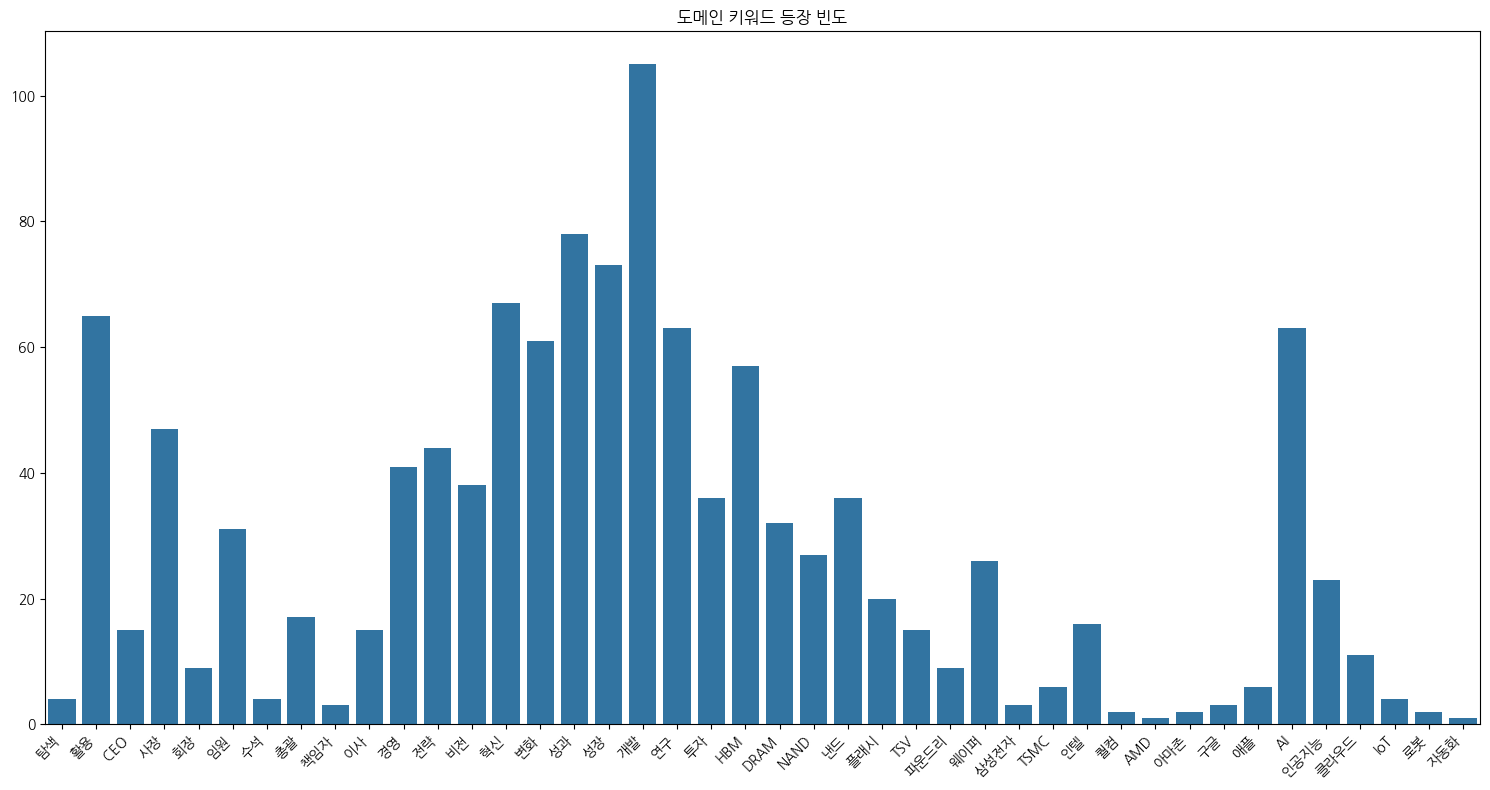

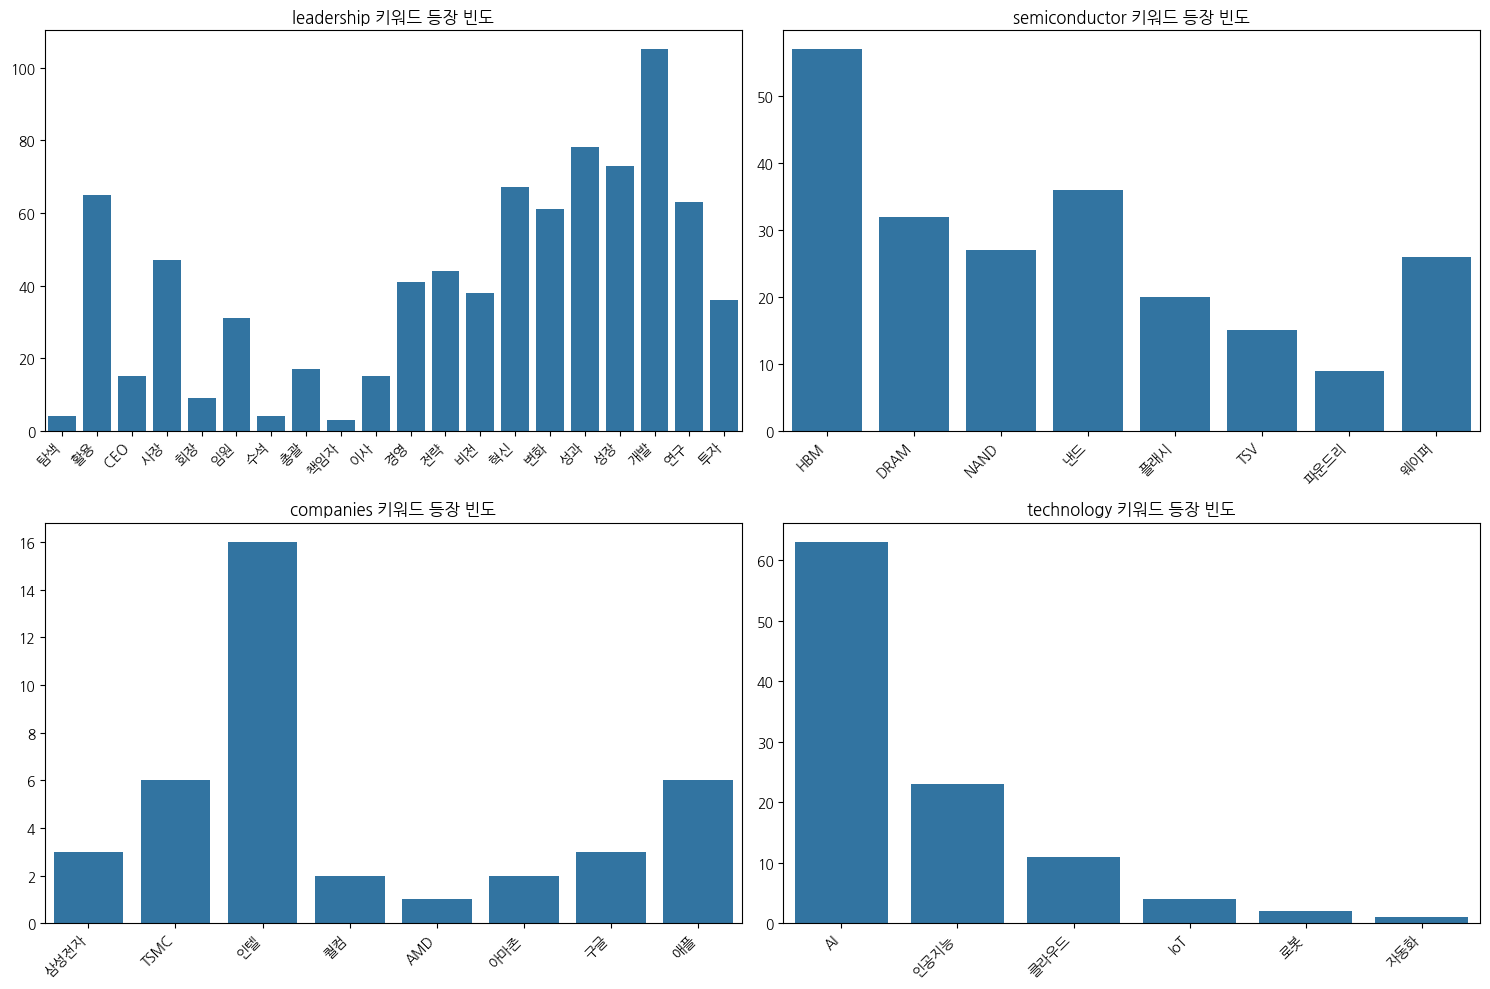

/tmp/ipykernel_9332/4255766449.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_count = df.groupby('year').apply(lambda x: sum(1 for content in x['processed_content'] if keyword in content))
/tmp/ipykernel_9332/4255766449.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_count = df.groupby('year').apply(lambda x: sum(1 for content in x['processed_content'] if keyword in content))
/tmp/i

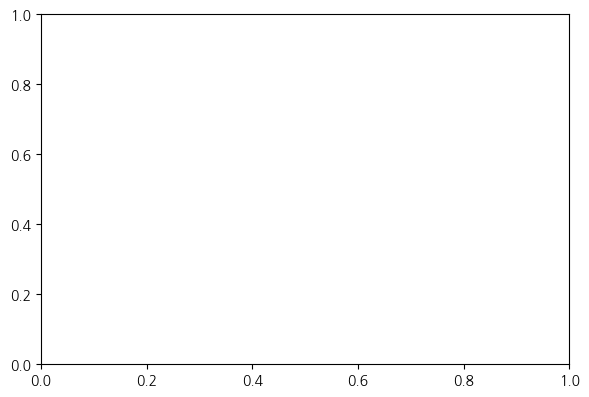

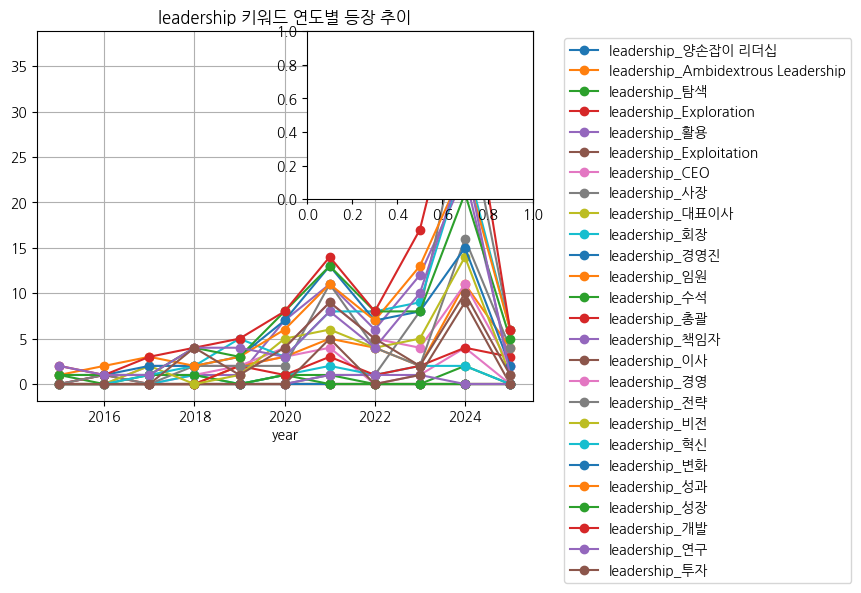

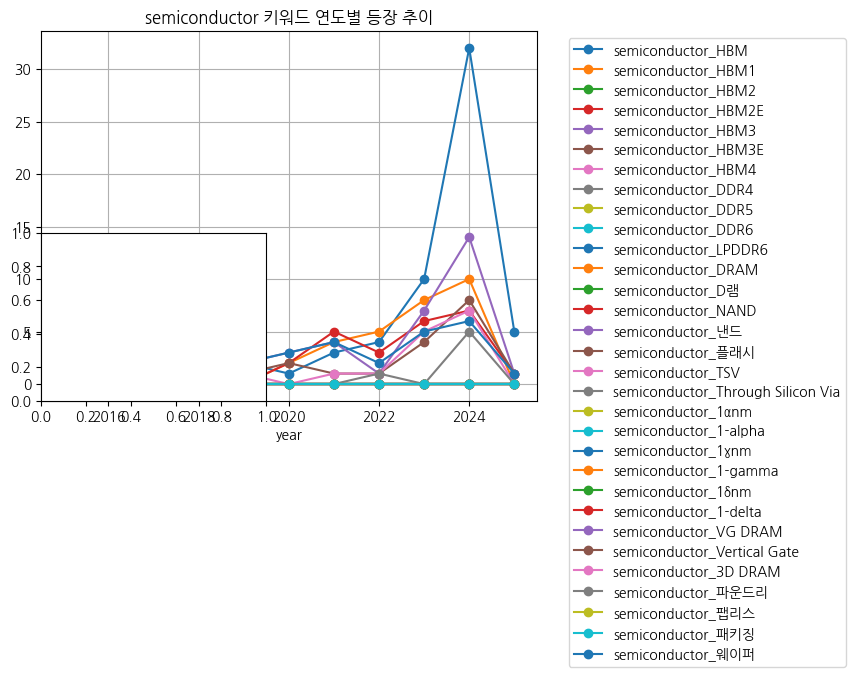

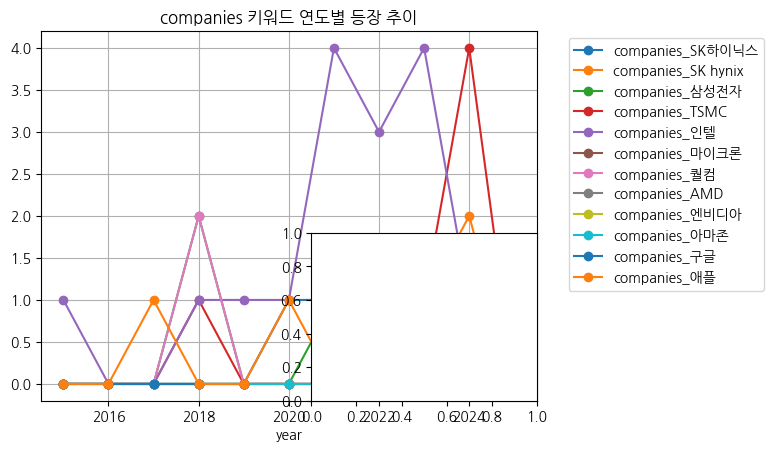

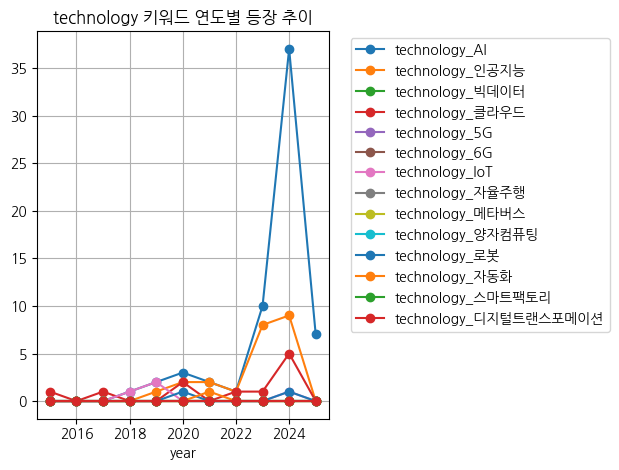

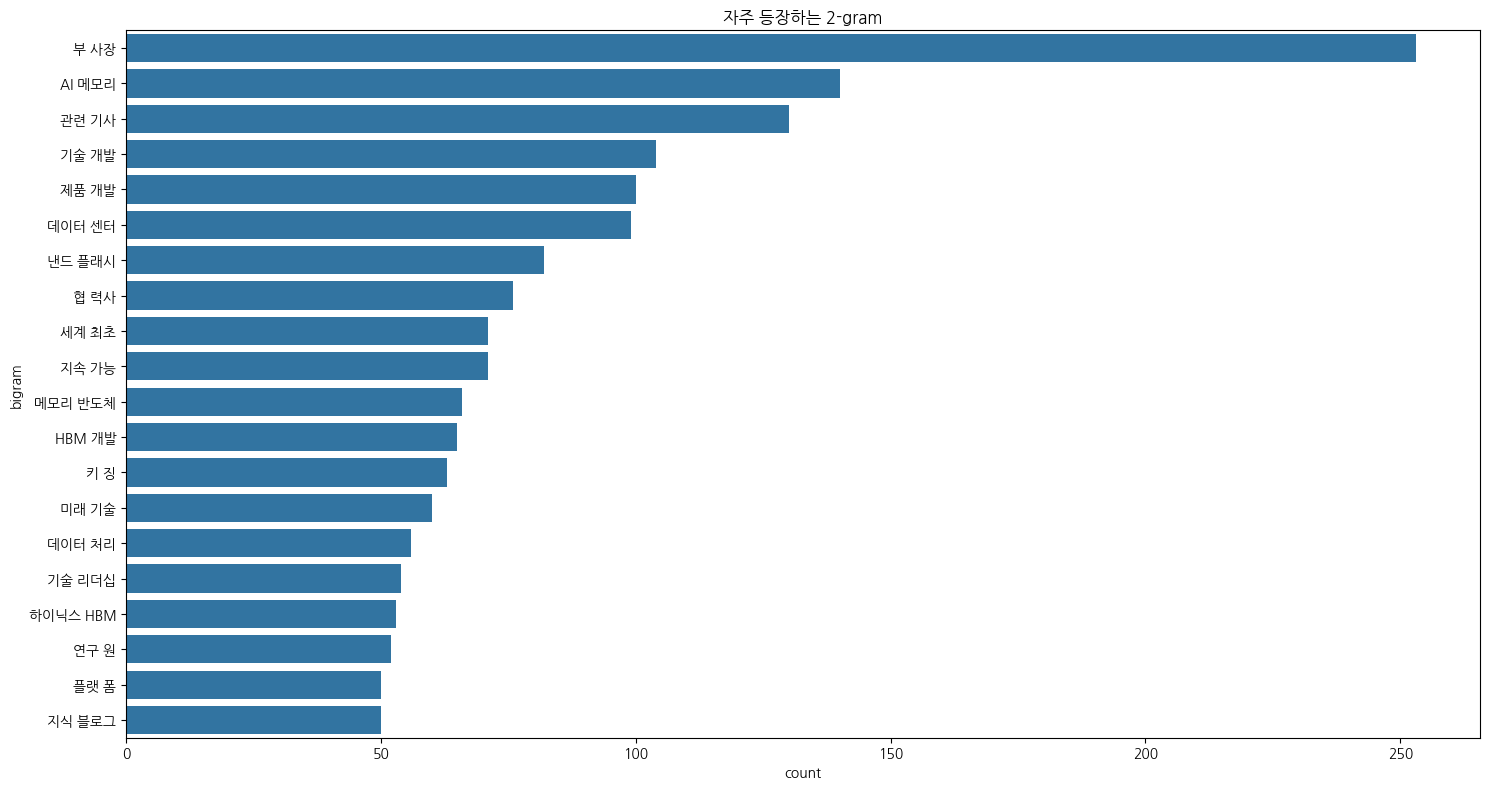

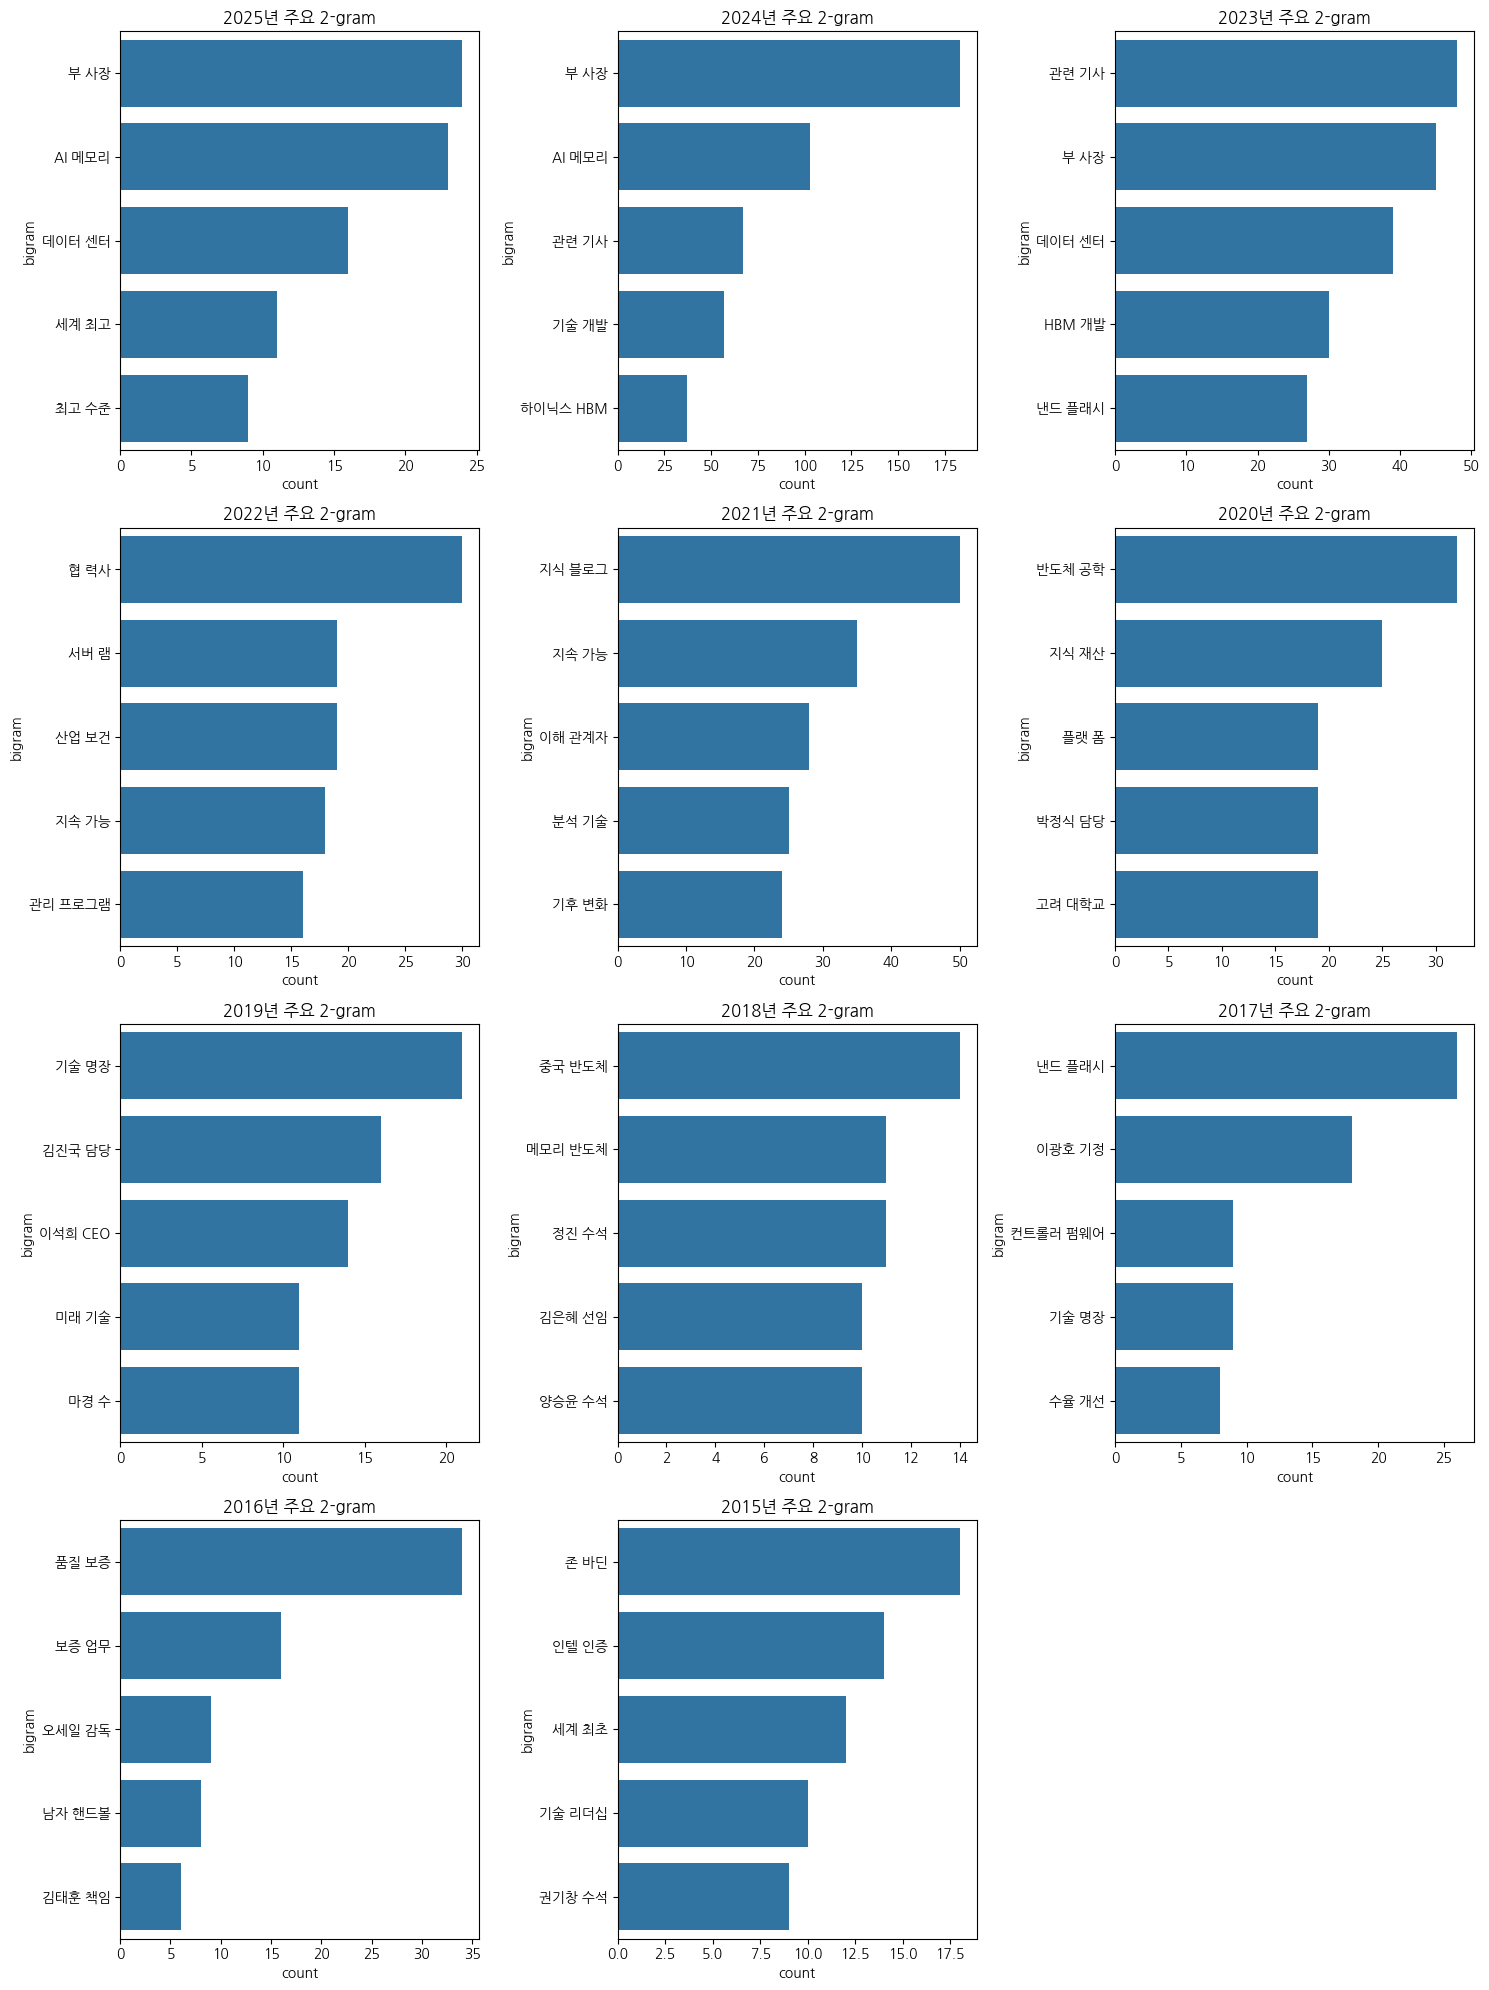

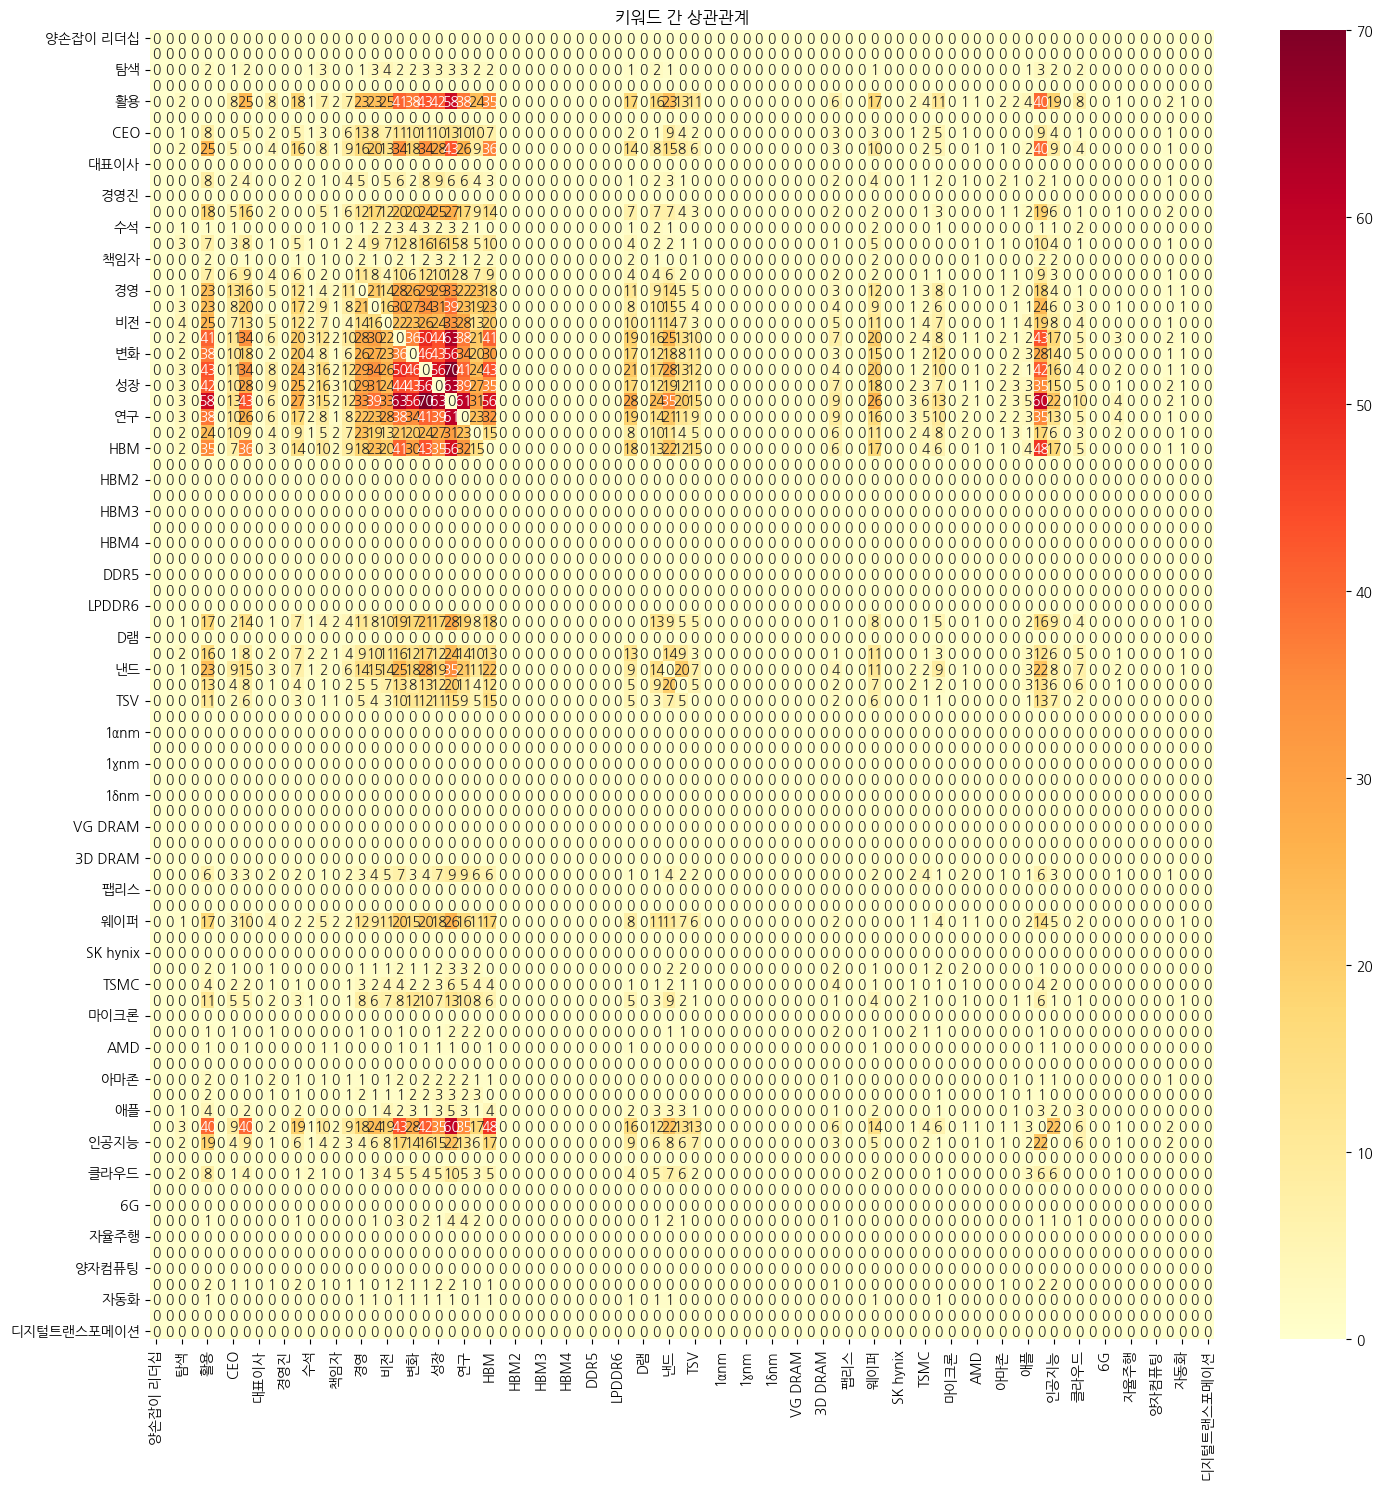

In [4]:

# 날짜 데이터에서 연도 추출
df['year'] = pd.to_datetime(df['date']).dt.year

# 키워드별 등장 빈도 분석
keyword_counts = {}
for category, keywords in domain_keywords.items():
    for keyword in keywords:
        count = sum(1 for content in df['processed_content'] if keyword in content)
        if count > 0:
            keyword_counts[keyword] = count

# 카테고리별 키워드 등장 빈도 시각화
plt.figure(figsize=(15, 8))
sns.barplot(x=list(keyword_counts.keys()), y=list(keyword_counts.values()))
plt.title('도메인 키워드 등장 빈도')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 카테고리별 키워드 등장 빈도 시각화 (카테고리별로 구분)
plt.figure(figsize=(15, 10))
for i, (category, keywords) in enumerate(domain_keywords.items(), 1):
    plt.subplot(2, 2, i)
    category_counts = {k: keyword_counts.get(k, 0) for k in keywords if k in keyword_counts}
    if category_counts:
        sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
        plt.title(f'{category} 키워드 등장 빈도')
        plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 연도별 키워드 추이 분석
yearly_keywords = pd.DataFrame()
for category, keywords in domain_keywords.items():
    for keyword in keywords:
        yearly_count = df.groupby('year').apply(lambda x: sum(1 for content in x['processed_content'] if keyword in content))
        yearly_keywords[f'{category}_{keyword}'] = yearly_count

# 연도별 키워드 등장 추이 시각화 (카테고리별로 구분)
plt.figure(figsize=(15, 10))
for i, (category, keywords) in enumerate(domain_keywords.items(), 1):
    plt.subplot(2, 2, i)
    category_columns = [col for col in yearly_keywords.columns if col.startswith(f'{category}_')]
    if category_columns:
        yearly_keywords[category_columns].plot(kind='line', marker='o')
        plt.title(f'{category} 키워드 연도별 등장 추이')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
plt.tight_layout()
plt.show()

# 2-gram 분석 결과 시각화
plt.figure(figsize=(15, 8))
bigram_df = pd.DataFrame(bigram_freq.most_common(20), columns=['bigram', 'count'])
bigram_df['bigram'] = bigram_df['bigram'].apply(lambda x: ' '.join(x))
sns.barplot(x='count', y='bigram', data=bigram_df)
plt.title('자주 등장하는 2-gram')
plt.tight_layout()
plt.show()

# 연도별 2-gram 분석
yearly_bigrams = {}
for year in df['year'].unique():
    year_texts = df[df['year'] == year]['processed_content']
    year_bigrams = []
    for text in year_texts:
        words = text.split()
        year_bigrams.extend(list(bigrams(words)))
    yearly_bigrams[year] = Counter(year_bigrams)

# 연도별 주요 2-gram 시각화
n_years = len(yearly_bigrams)
n_cols = 3
n_rows = (n_years + n_cols - 1) // n_cols  # 올림 나눗셈

plt.figure(figsize=(15, 5*n_rows))
for i, (year, bigrams) in enumerate(yearly_bigrams.items(), 1):
    plt.subplot(n_rows, n_cols, i)
    top_bigrams = pd.DataFrame(bigrams.most_common(5), columns=['bigram', 'count'])
    top_bigrams['bigram'] = top_bigrams['bigram'].apply(lambda x: ' '.join(x))
    sns.barplot(x='count', y='bigram', data=top_bigrams)
    plt.title(f'{year}년 주요 2-gram')
plt.tight_layout()
plt.show()

# 키워드 간 상관관계 분석
keyword_matrix = pd.DataFrame(0, index=all_domain_keywords, columns=all_domain_keywords)
for text in df['processed_content']:
    words = set(text.split())
    for i, keyword1 in enumerate(all_domain_keywords):
        for keyword2 in all_domain_keywords[i+1:]:
            if keyword1 in words and keyword2 in words:
                keyword_matrix.loc[keyword1, keyword2] += 1
                keyword_matrix.loc[keyword2, keyword1] += 1

# 키워드 간 상관관계 히트맵
plt.figure(figsize=(15, 15))
sns.heatmap(keyword_matrix, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('키워드 간 상관관계')
plt.tight_layout()
plt.show()

## 4. 워드클라우드 생성
1. 연도별 워드클라우드 생성
 - 각 연도별로 텍스트 데이터를 추출하고 단어 빈도를 계산
 - subplot을 사용하여 연도별 워드클라우드를 나란히 표시
2. 워드클라우드 설정 개선
 - max_words 파라미터 추가하여 표시할 단어 수 제한
 - 연도별은 50개, 전체 기간은 100개의 단어로 설정
3. 레이아웃 최적화
 - 연도 수에 따라 동적으로 subplot 행 수 계산
 - figure 크기를 내용에 맞게 조정

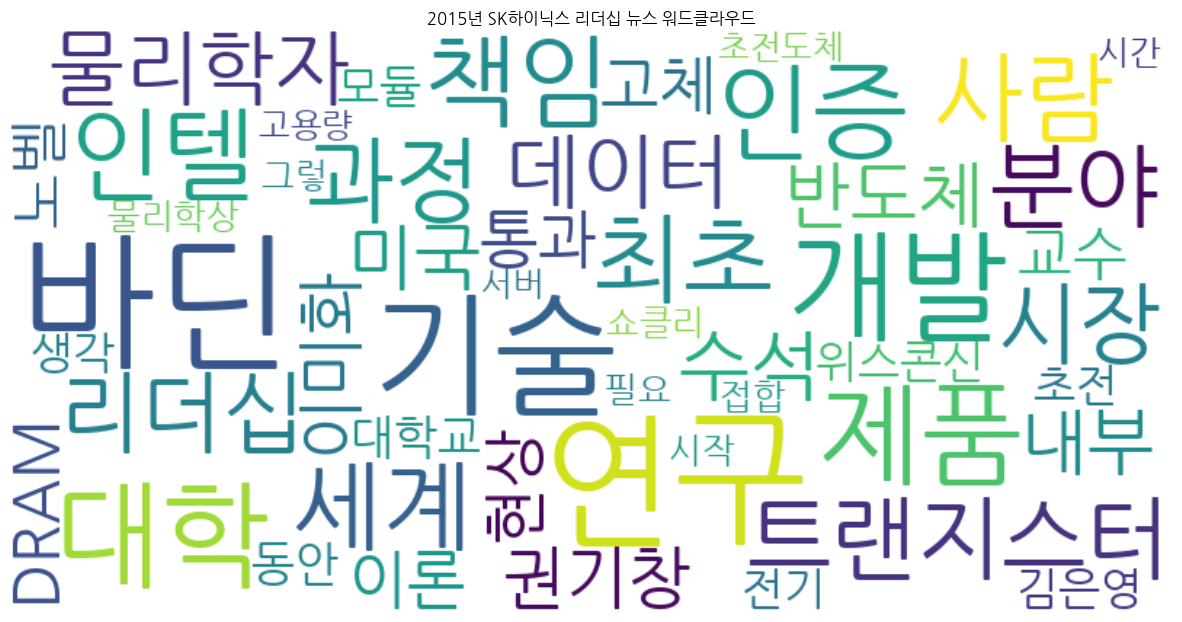

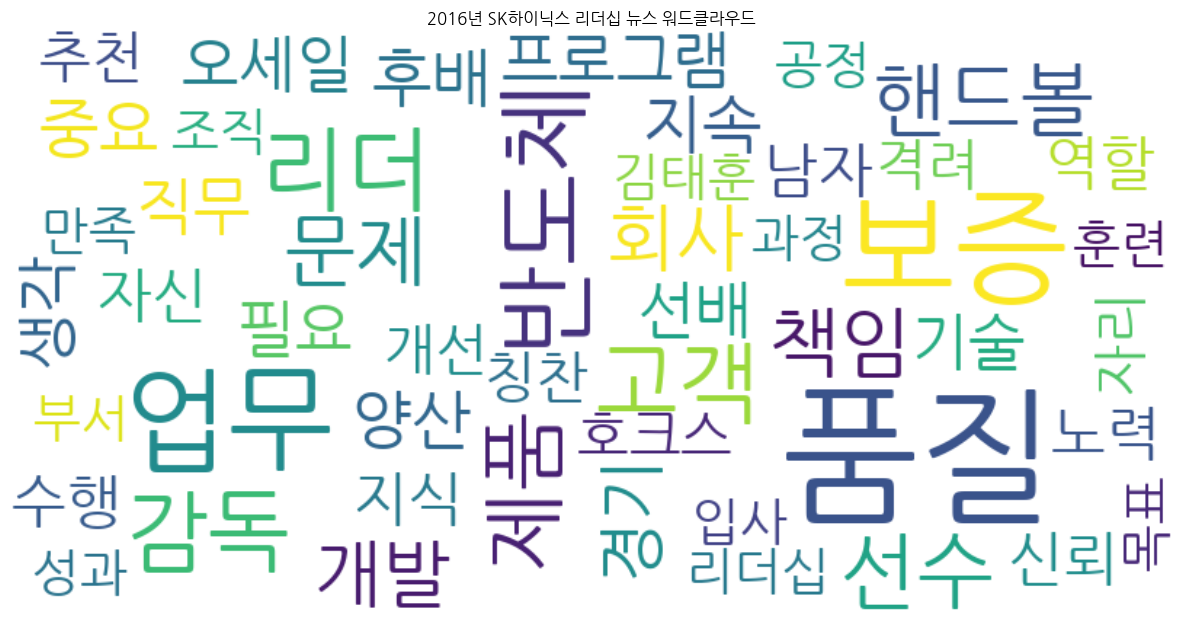

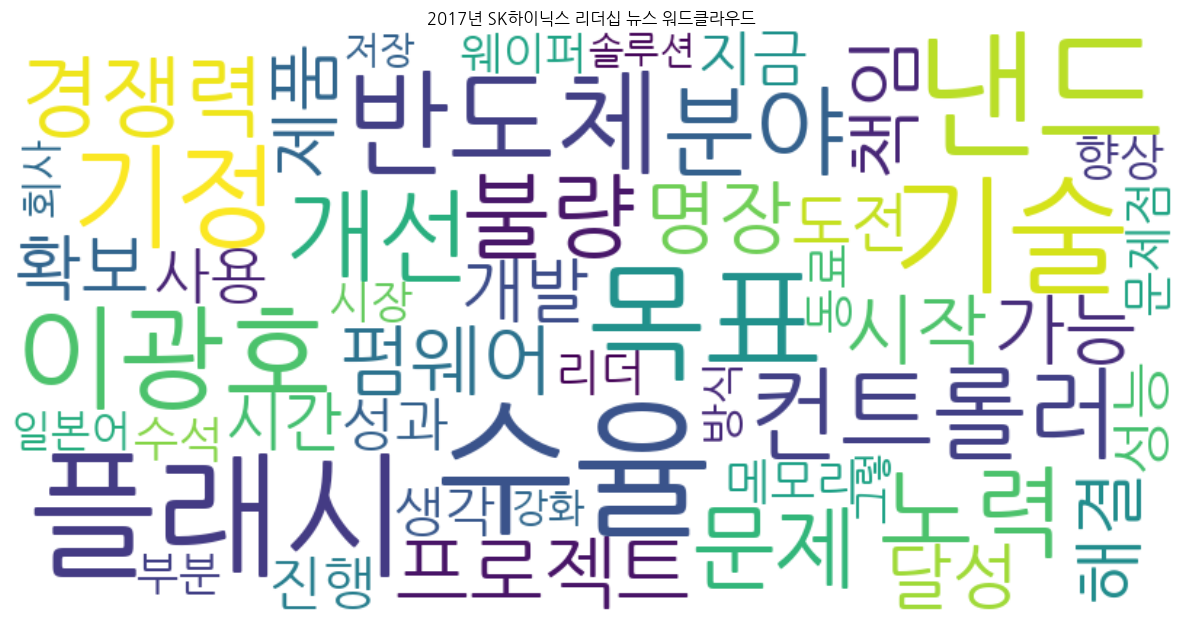

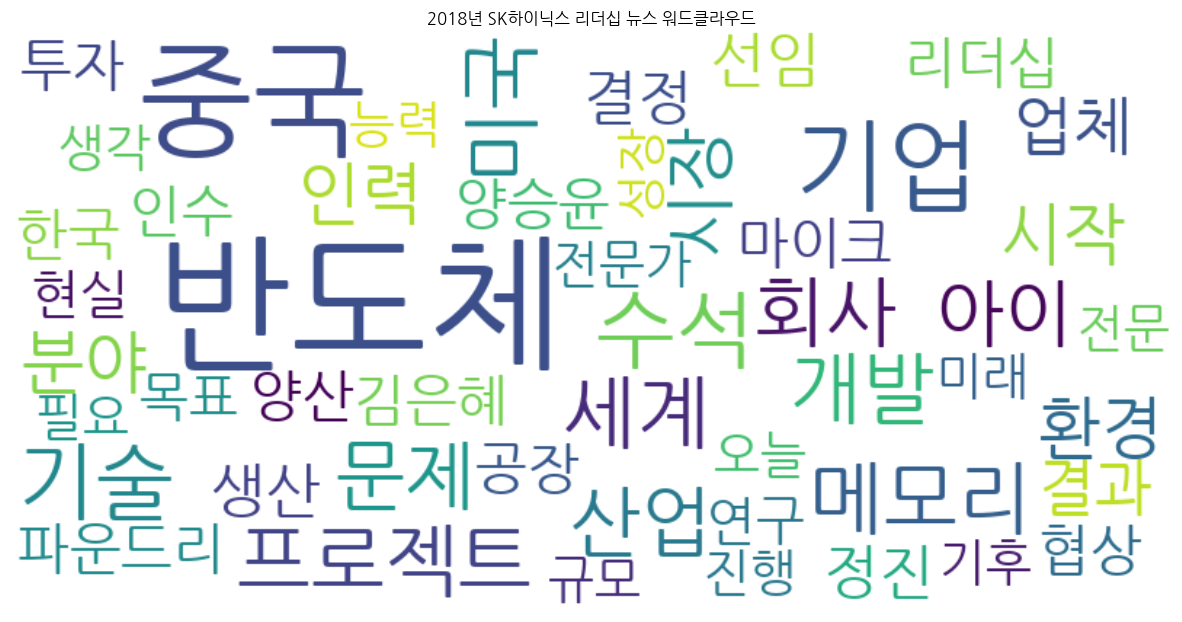

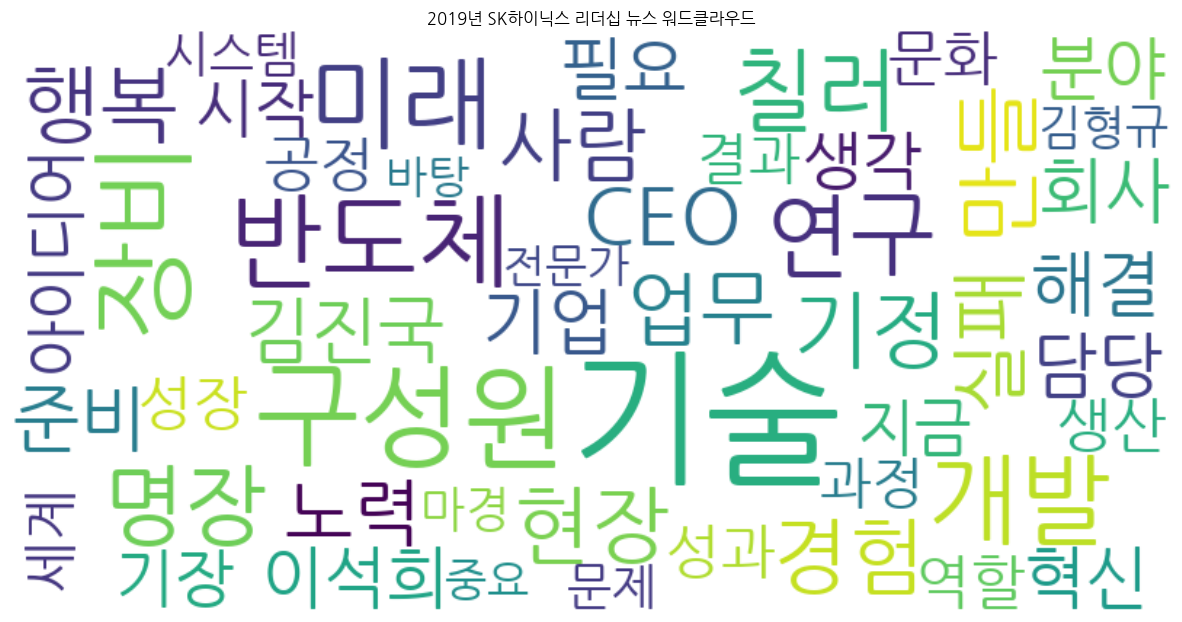

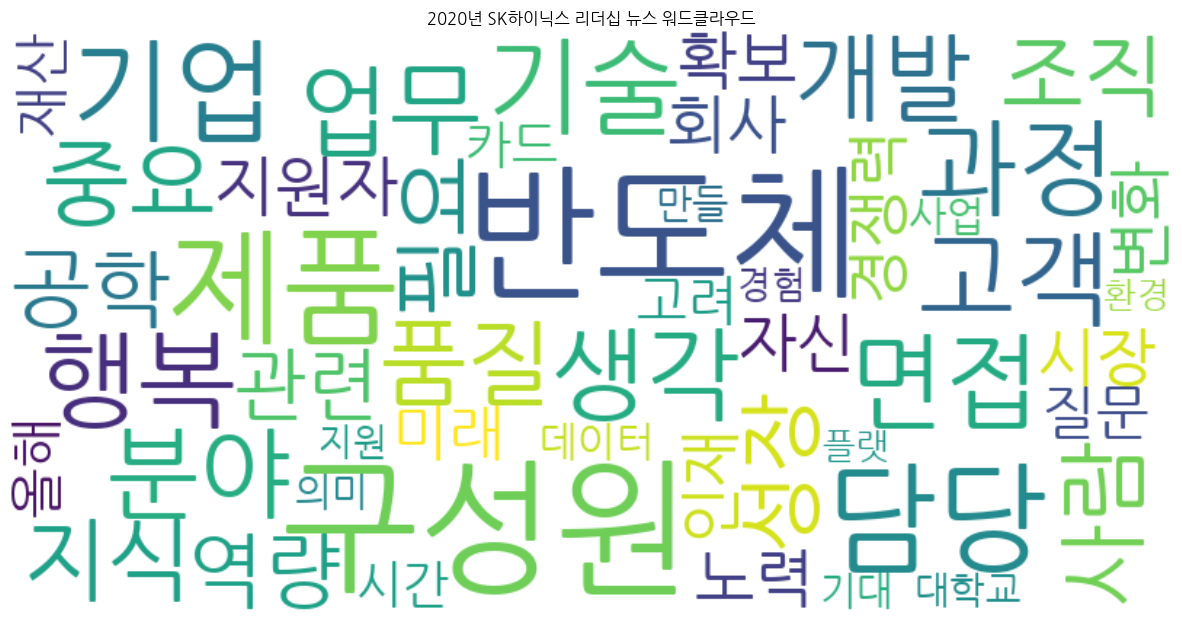

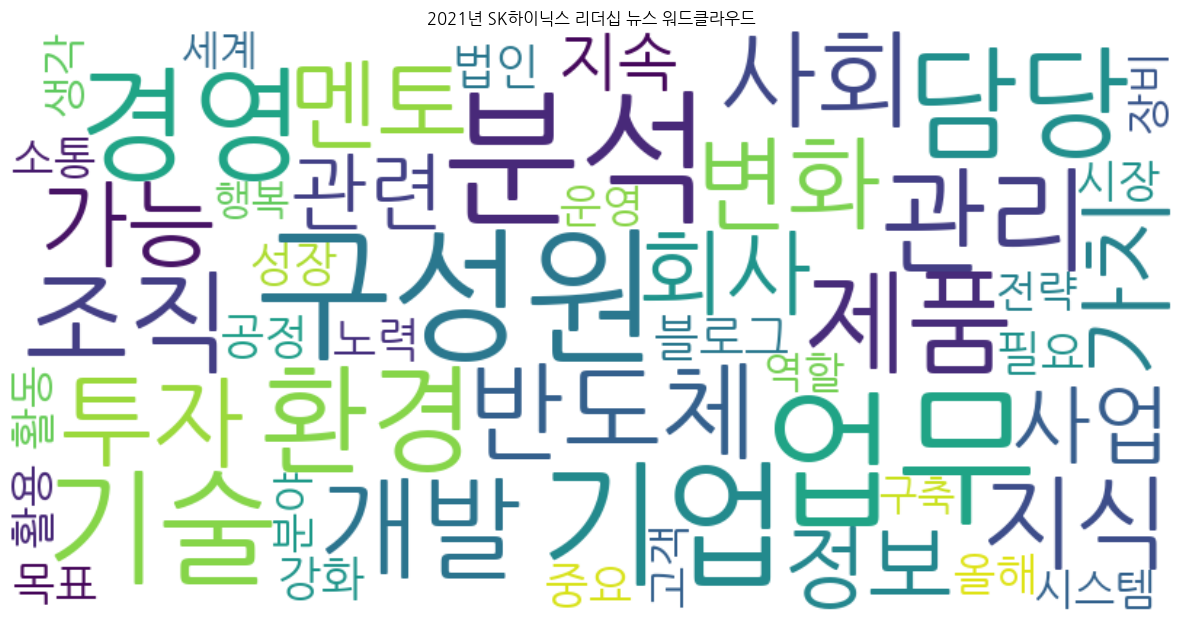

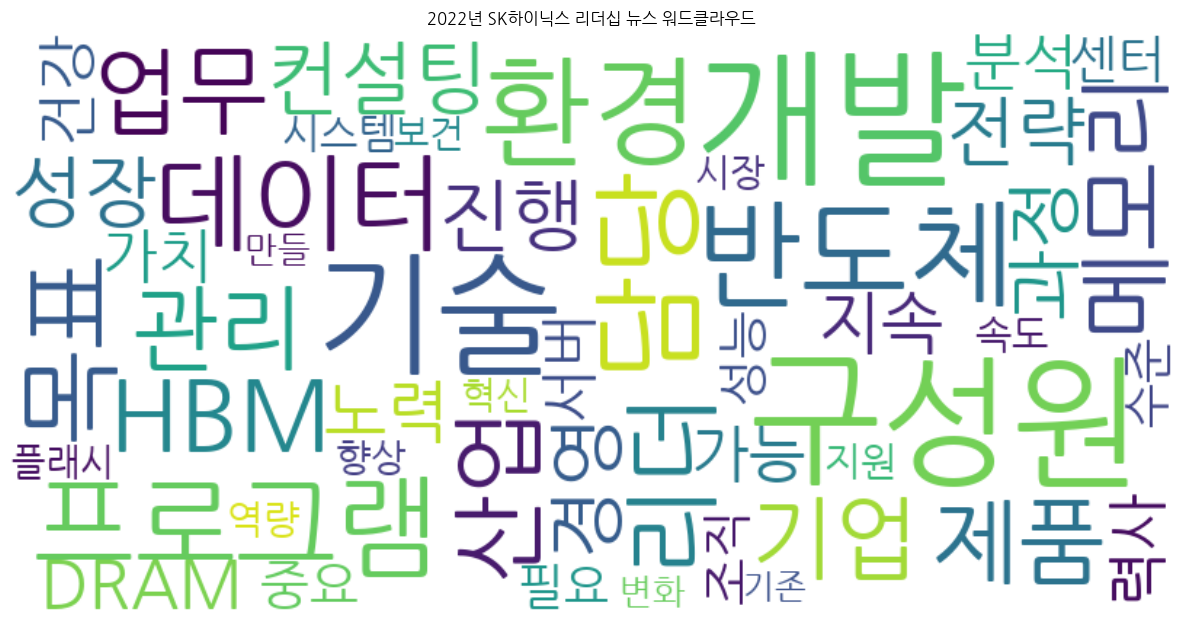

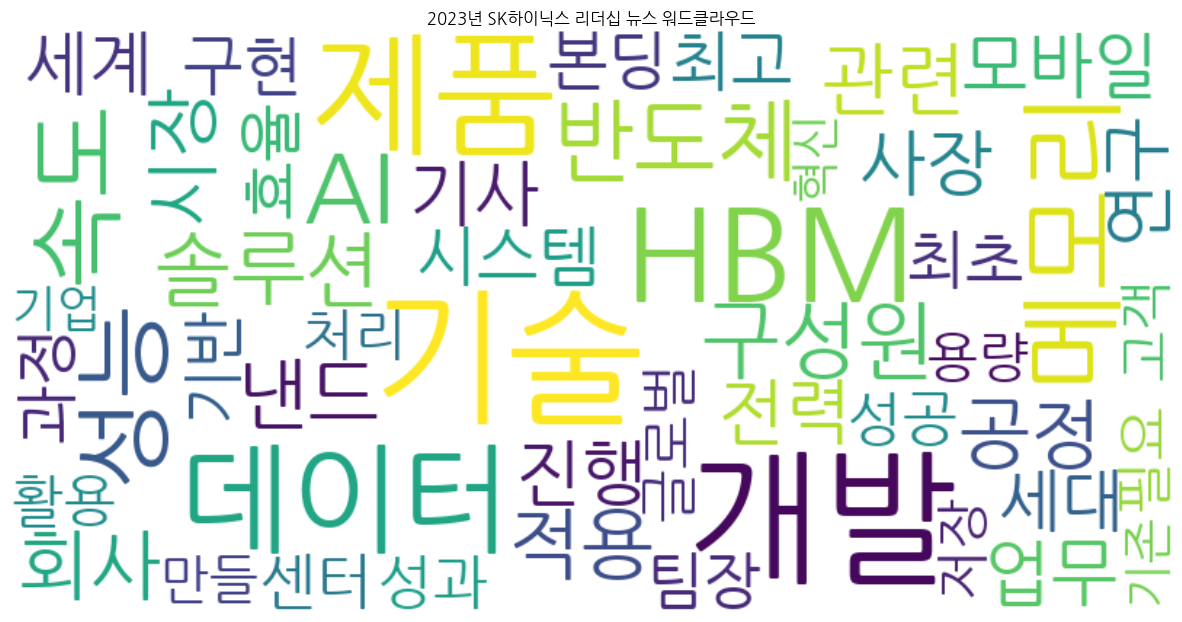

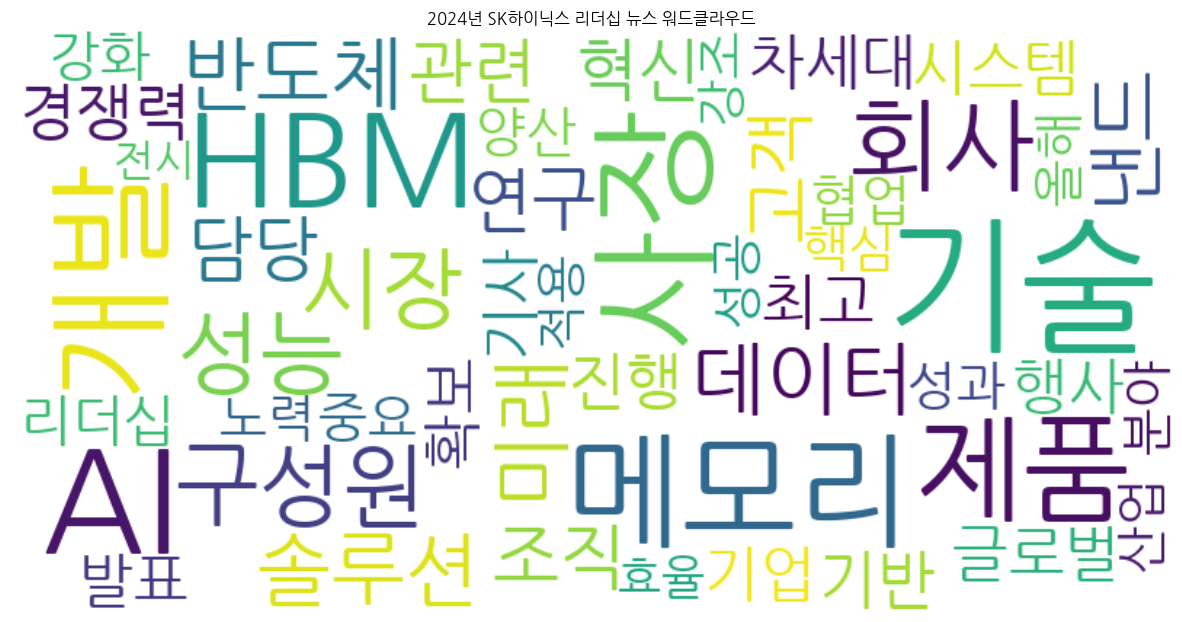

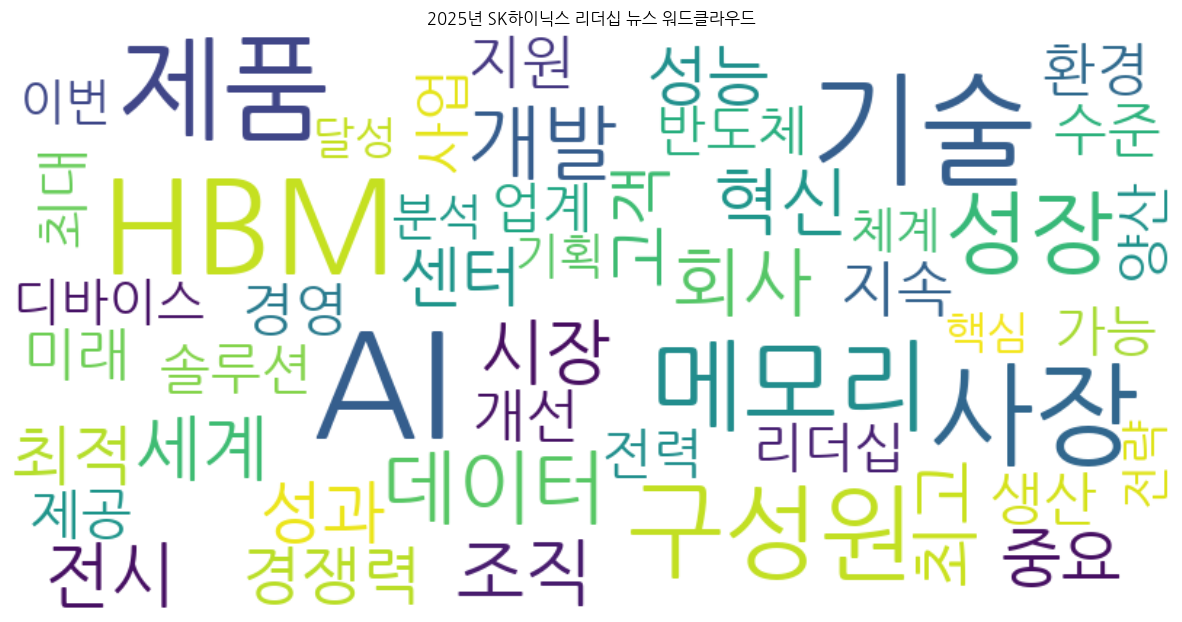

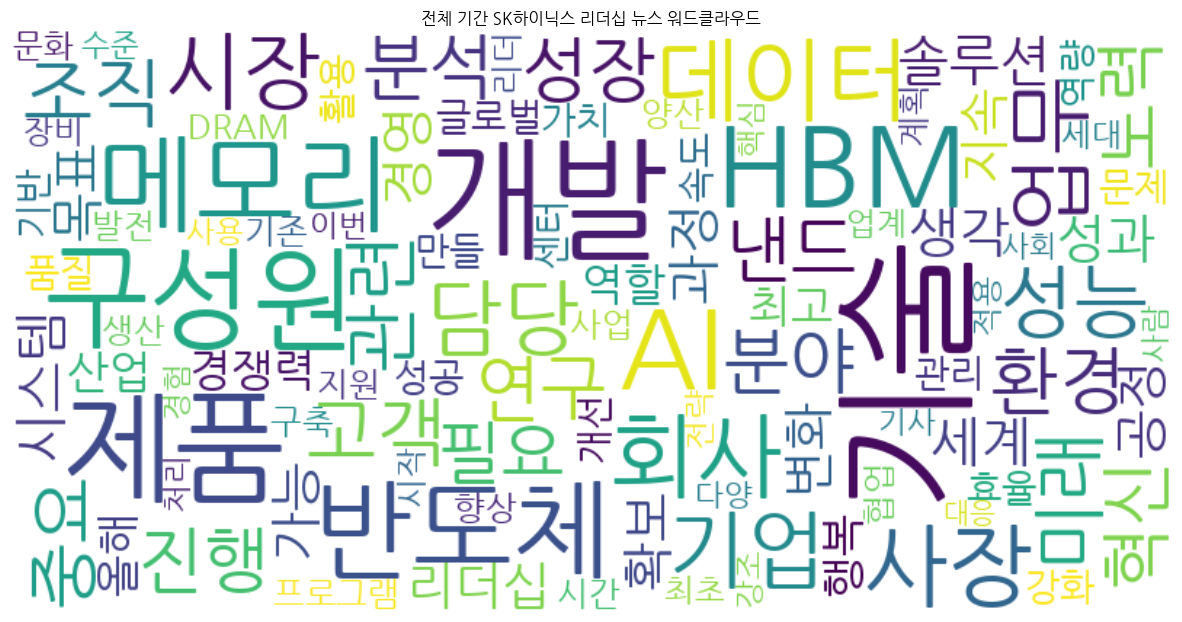

In [7]:
# 제외할 단어 목록 정의
exclude_words = {
    '하이닉스', 'sk', 'sk하이닉스', 'sk하이닉스의', 'sk하이닉스는', 'sk하이닉스가',
    '있', '되', '것', '등', '들', '및', '이', '를', '을', '의', '에', '로', '로써',
    '년', '월', '일', '시', '분', '초', '주', '개', '명', '회', '차', '번'
}

# 한 글자 단어와 제외할 단어 필터링 함수
def filter_words(word_counts):
    return {word: count for word, count in word_counts.items() 
            if len(word) > 1 and word not in exclude_words}

# 연도별 워드클라우드 생성
for year in sorted(df['year'].unique()):
    # 해당 연도의 텍스트 데이터 추출
    year_texts = df[df['year'] == year]['processed_content']
    year_text = ' '.join(year_texts)
    
    # 해당 연도의 단어 빈도 계산 및 필터링
    year_word_counts = Counter(year_text.split())
    year_word_counts = filter_words(year_word_counts)
    
    # 워드클라우드 생성
    wordcloud = WordCloud(
        font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
        width=800,
        height=400,
        background_color='white',
        max_words=50,  # 상위 50개 단어만 표시
        min_font_size=10,  # 최소 폰트 크기 설정
        max_font_size=100  # 최대 폰트 크기 설정
    ).generate_from_frequencies(year_word_counts)
    
    # 별도의 figure로 워드클라우드 표시
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{year}년 SK하이닉스 리더십 뉴스 워드클라우드')
    plt.show()

# 전체 기간 워드클라우드 생성
all_text = ' '.join(df['processed_content'])
all_word_counts = Counter(all_text.split())
all_word_counts = filter_words(all_word_counts)

plt.figure(figsize=(15, 8))
wordcloud = WordCloud(
    font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    width=800,
    height=400,
    background_color='white',
    max_words=100,  # 전체 기간은 더 많은 단어 표시
    min_font_size=10,
    max_font_size=100
).generate_from_frequencies(all_word_counts)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('전체 기간 SK하이닉스 리더십 뉴스 워드클라우드')
plt.show()

## 5. 연도별 토픽 분석

LDA를 사용한 연도별 토픽 모델링

In [15]:
# 5. 연도별 토픽 분석
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import re

# 도메인 키워드 정의
domain_keywords = {
    '기술': [
        'HBM', 'HBM1', 'HBM2', 'HBM2E', 'HBM3', 'HBM3E', 'HBM4',
        'DDR4', 'DDR5', 'DDR6', 'LPDDR6',
        'DRAM', 'D램', 'NAND', '낸드', '플래시',
        'TSV', 'Through Silicon Via',
        '1αnm', '1-alpha', '1γnm', '1-gamma', '1δnm', '1-delta',
        'VG DRAM', 'Vertical Gate', '3D DRAM',
        '파운드리', '팹리스', '패키징', '웨이퍼'
    ],
    '기업': [
        'SK하이닉스', 'SK hynix', '삼성전자', 'TSMC', '인텔', '마이크론',
        '퀄컴', 'AMD', '엔비디아', '아마존', '구글', '애플'
    ],
    '리더십': [
        '양손잡이 리더십', 'Ambidextrous Leadership', '탐색', 'Exploration', '활용', 'Exploitation',
        'CEO', '사장', '대표이사', '회장', '경영진', '임원', '수석', '총괄', '책임자', '이사',
        '경영', '전략', '비전', '혁신', '변화', '성과', '성장', '개발', '연구', '투자'
    ],
    '혁신': [
        'AI', '인공지능', '빅데이터', '클라우드', '5G', '6G', 'IoT',
        '자율주행', '메타버스', '양자컴퓨팅', '로봇', '자동화',
        '스마트팩토리', '디지털트랜스포메이션'
    ]
}
# 전체 도메인 키워드 리스트 생성
all_domain_keywords = [keyword.lower() for keywords in domain_keywords.values() for keyword in keywords]

def preprocess_text_for_topic(text):
    if pd.isna(text):
        return []
    
    text = str(text).lower()  # 소문자 변환
    
    # 1. 도메인 키워드 보존
    preserved_words = []
    for keyword in all_domain_keywords:
        if keyword in text:
            text = text.replace(keyword, f" {keyword} ")
            preserved_words.append(keyword)
    
    # 2. 영어-한글 혼합 형태 보존
    mixed_pattern = re.compile(r'[가-힣]+[A-Za-z]+|[A-Za-z]+[가-힣]+')
    mixed_words = mixed_pattern.findall(text)
    for word in mixed_words:
        word = word.lower()
        if word not in preserved_words:
            text = text.replace(word, f" {word} ")
            preserved_words.append(word)
    
    # 3. 기본 전처리
    text = re.sub(r'[^가-힣A-Za-z0-9\s]', ' ', text)  # 특수문자 제거
    words = text.split()
    
    # 4. 단어 필터링
    filtered_words = []
    for word in words:
        if word in preserved_words:  # 보존된 키워드는 그대로 유지
            filtered_words.append(word)
        elif len(word) > 1:  # 한 글자 단어 제외
            filtered_words.append(word)
    
    return filtered_words  # 토큰화된 리스트 반환

# 연도별 토픽 모델링 함수
def perform_topic_modeling(texts, num_topics=3):
    # 텍스트 전처리
    tokenized_texts = [preprocess_text_for_topic(text) for text in texts]
    
    # 빈 문서 제거
    tokenized_texts = [text for text in tokenized_texts if text]
    
    if not tokenized_texts:
        raise ValueError("전처리 후 텍스트가 없습니다.")
    
    # 딕셔너리 생성
    dictionary = corpora.Dictionary(tokenized_texts)
    
    # 극단적인 빈도의 단어만 필터링
    dictionary.filter_extremes(no_below=2, no_above=0.9)
    
    # 코퍼스 생성
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
    
    if not corpus:
        raise ValueError("생성된 코퍼스가 비어있습니다.")
    
    # LDA 모델 학습
    lda_model = models.LdaModel(
        corpus,
        num_topics=num_topics,
        id2word=dictionary,
        passes=20,
        alpha='auto',
        random_state=42
    )
    
    return lda_model, corpus, dictionary

# 연도별 데이터 분리 및 토픽 모델링
yearly_topics = {}
yearly_models = {}

for year in sorted(df['year'].unique()):
    year_texts = df[df['year'] == year]['processed_content']
    
    if len(year_texts) > 0:
        try:
            print(f"\n{year}년 토픽 모델링 결과:")
            
            # 토픽 모델링 수행
            lda_model, corpus, dictionary = perform_topic_modeling(year_texts)
            yearly_models[year] = (lda_model, corpus, dictionary)
            
            # 토픽 추출
            topics = {}
            for idx, topic in lda_model.show_topics(formatted=False, num_words=7):
                topics[idx] = [(word, round(prob, 4)) for word, prob in topic]
                print(f"\n토픽 {idx+1}:")
                print(", ".join([f"{word} ({prob:.4f})" for word, prob in topics[idx]]))
            
            yearly_topics[year] = topics
            
        except Exception as e:
            print(f"{year}년 처리 중 오류 발생: {str(e)}")
            continue


# 시각화 코드는 이전과 동일...


2015년 토픽 모델링 결과:
2015년 처리 중 오류 발생: cannot compute LDA over an empty collection (no terms)

2016년 토픽 모델링 결과:

토픽 1:
리더 (0.0151), 업무 (0.0150), 후배 (0.0149), 회사 (0.0149), 선배 (0.0148), 반도체 (0.0148), 책임 (0.0148)

토픽 2:
리더 (0.1453), 선배 (0.0666), 후배 (0.0654), 마음 (0.0381), 시작 (0.0310), 넘치 (0.0309), 도전 (0.0238)

토픽 3:
업무 (0.1202), 반도체 (0.0895), 제품 (0.0665), 문제 (0.0549), 책임 (0.0544), 회사 (0.0431), 지속 (0.0395)

2017년 토픽 모델링 결과:

토픽 1:
목표 (0.0869), 개선 (0.0632), 불량 (0.0490), 달성 (0.0395), 문제 (0.0348), 시간 (0.0300), 방식 (0.0253)

토픽 2:
제품 (0.0868), 사용 (0.0764), 확보 (0.0659), 그렇 (0.0451), 발생 (0.0451), 강화 (0.0347), 불량 (0.0243)

토픽 3:
시작 (0.0543), 동료 (0.0469), 생각 (0.0469), 도전 (0.0395), 목표 (0.0321), 문제 (0.0321), 시간 (0.0247)

2018년 토픽 모델링 결과:

토픽 1:
프로젝트 (0.0368), 아이 (0.0308), 문제 (0.0268), 개발 (0.0227), 결과 (0.0187), 결정 (0.0187), 목표 (0.0167)

토픽 2:
반도체 (0.0827), 중국 (0.0603), 기업 (0.0380), 메모리 (0.0369), 회사 (0.0279), 산업 (0.0202), 기술 (0.0197)

토픽 3:
반도체 (0.0644), 중국 (0.0300), 기술 (0.0243), 기업 (0.0223), 공장 (0.0212), 

시각화화

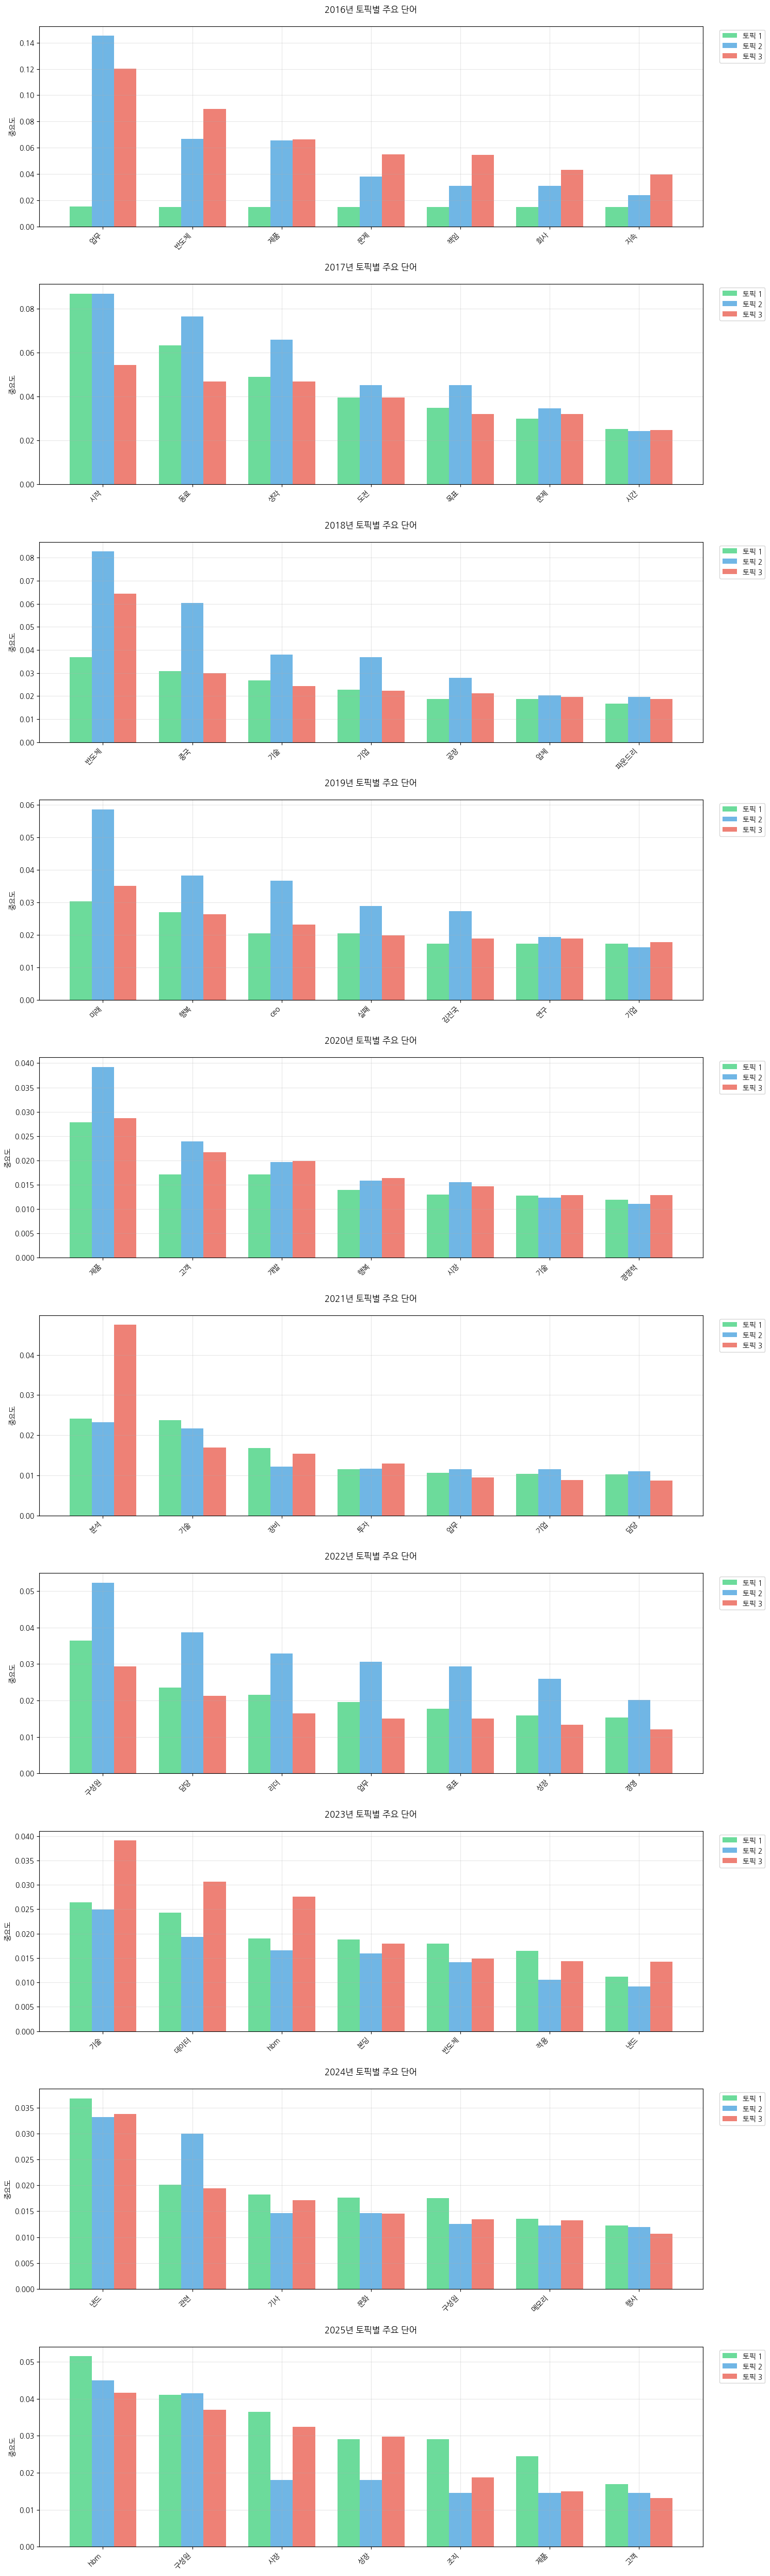

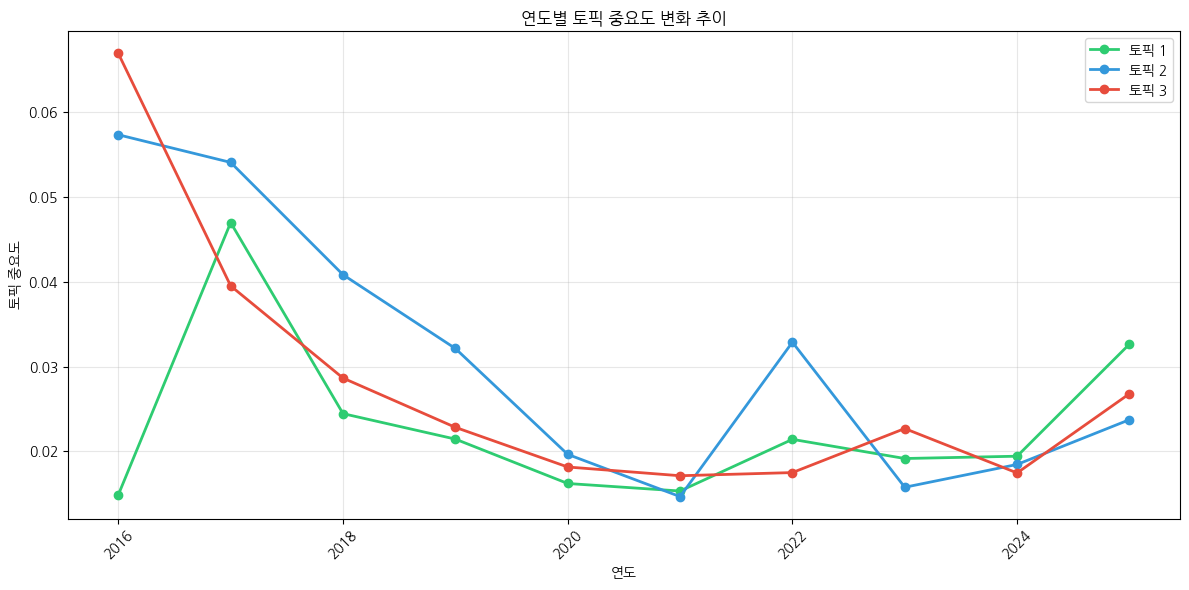


2016년 토픽 시각화가 'topic_visualization_2016.html'에 저장되었습니다.

2017년 토픽 시각화가 'topic_visualization_2017.html'에 저장되었습니다.

2018년 토픽 시각화가 'topic_visualization_2018.html'에 저장되었습니다.

2019년 토픽 시각화가 'topic_visualization_2019.html'에 저장되었습니다.

2020년 토픽 시각화가 'topic_visualization_2020.html'에 저장되었습니다.

2021년 토픽 시각화가 'topic_visualization_2021.html'에 저장되었습니다.

2022년 토픽 시각화가 'topic_visualization_2022.html'에 저장되었습니다.

2023년 토픽 시각화가 'topic_visualization_2023.html'에 저장되었습니다.

2024년 토픽 시각화가 'topic_visualization_2024.html'에 저장되었습니다.

2025년 토픽 시각화가 'topic_visualization_2025.html'에 저장되었습니다.


In [16]:
# 연도별 토픽 시각화 (개선된 버전)
n_years = len(yearly_topics)
fig, axes = plt.subplots(n_years, 1, figsize=(15, 5*n_years))
if n_years == 1:
    axes = [axes]

colors = ['#2ecc71', '#3498db', '#e74c3c']  # 각 토픽별 색상

for ax, (year, topics) in zip(axes, sorted(yearly_topics.items())):
    # 토픽별 데이터 준비
    for topic_idx, topic_words in topics.items():
        words, weights = zip(*topic_words[:7])  # 상위 7개 단어
        x_pos = np.arange(len(words))
        width = 0.25  # 막대 너비
        
        # 막대 그래프 그리기
        ax.bar(x_pos + (topic_idx * width), 
               weights, 
               width, 
               label=f'토픽 {topic_idx+1}',
               color=colors[topic_idx],
               alpha=0.7)
    
    # 그래프 꾸미기
    ax.set_title(f'{year}년 토픽별 주요 단어', pad=20, fontsize=12)
    ax.set_xticks(x_pos + width)
    ax.set_xticklabels(words, rotation=45, ha='right')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_ylabel('중요도')

plt.tight_layout()
plt.show()

# 연도별 토픽 변화 추이 시각화
topic_trends = pd.DataFrame()

for year in sorted(yearly_topics.keys()):
    year_topic_weights = {}
    
    # 각 토픽의 주요 단어들의 평균 가중치 계산
    for topic_idx, topic_words in yearly_topics[year].items():
        avg_weight = np.mean([weight for _, weight in topic_words])
        year_topic_weights[f'토픽 {topic_idx+1}'] = avg_weight
    
    topic_trends = pd.concat([topic_trends, 
                            pd.DataFrame([year_topic_weights], index=[year])])

# 토픽 변화 추이 시각화
plt.figure(figsize=(12, 6))
for i, column in enumerate(topic_trends.columns):
    plt.plot(topic_trends.index, topic_trends[column], 
             marker='o', 
             color=colors[i], 
             linewidth=2,
             label=column)

plt.title('연도별 토픽 중요도 변화 추이')
plt.xlabel('연도')
plt.ylabel('토픽 중요도')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# pyLDAvis 시각화
for year, (lda_model, corpus, dictionary) in yearly_models.items():
    try:
        vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
        pyLDAvis.save_html(vis_data, f'topic_visualization_{year}.html')
        print(f"\n{year}년 토픽 시각화가 'topic_visualization_{year}.html'에 저장되었습니다.")
    except Exception as e:
        print(f"\n{year}년 토픽 시각화 중 오류 발생: {str(e)}")